# 特徴量作成と選択の自動化
### House Prices: Advanced Regression Techniques

In [526]:
% matplotlib inline

from __future__ import print_function

import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error

## データの読み込み

In [527]:
data = pd.read_csv("dataset/ML_project_train3.csv")

In [528]:
# NANに平均値を割り当て
train_col = ['LotFrontage']
for col in train_col:
    data[col] = data[col].fillna(data[col].mean())

In [529]:
# NANに0を割り当て
# 平均値でNANを穴埋め
train_col = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea']
for col in train_col:
    data[col] = data[col].fillna(0)

In [530]:
# 最頻値を割り当て
train_col = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
for col in train_col:
    dic = {}
    Index = data[col].value_counts(dropna=False).index
    for n in range(0,len(Index)):
        dic[data[col].value_counts(dropna=False).values[n]] = Index[n]
    data[col] = data[col].fillna(dic[max(dic)])

In [531]:
# NoでNANを穴埋め
train_col = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType'
             ,'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
for col in train_col:
    data[col] = data[col].fillna('NO')

In [532]:
dummy_data_ot = pd.get_dummies(data[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'
                                     ,'FireplaceQu','PoolQC','Fence','MiscFeature']], drop_first = True) 

In [431]:
dummy_data_ot.head()

,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NO,BsmtQual_TA,BsmtCond_Gd,BsmtCond_NO,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,...,PoolQC_Gd,PoolQC_NO,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NO,MiscFeature_NO,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0
1,0,1,0,0,0,0,0,1,1,0,...,0,1,0,0,0,1,1,0,0,0
2,0,1,0,0,0,0,0,1,0,1,...,0,1,0,0,0,1,1,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0


In [533]:
# ダミー変数作成
dummy_col = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood'
                                   ,'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType'
                                   ,'HouseStyle','FireplaceQu','PoolQC','Fence','MiscFeature','ExterQual','ExterCond','Foundation','Heating'
                                   ,'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual'
                                   ,'GarageCond','PavedDrive','SaleType','SaleCondition']
#dummy_data = pd.get_dummies(data[dummy_col], drop_first = True) 
dummy_data = pd.get_dummies(data[dummy_col], drop_first = True) 
#FireplaceQu,'PoolQC','Fence','MiscFeature'

In [534]:
data2 = pd.merge(data, dummy_data, left_index=True, right_index=True)
data2 = pd.merge(data2, dummy_data_ot, left_index=True, right_index=True)

In [535]:
# 特徴量の作成　OverallQual div buily, OverallQual div remodely
data2['Qual_div_Built'] = data2['OverallQual'] / data2['YearBuilt'] 
data2['Qual_div_Remod'] = data2['OverallQual'] / data2['YearRemodAdd']
#data2['YBuild_div_GarageCar'] = data2['YearBuilt'] / (data2['GarageCars']+0.01)
#data2['GrLivArea_div_BedroomAbvGr'] = data2['GrLivArea'] / (data2['BedroomAbvGr']+0.01)

In [329]:
data2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence_MnPrv_y,Fence_MnWw_y,Fence_NO_y,MiscFeature_NO_y,MiscFeature_Othr_y,MiscFeature_Shed_y,MiscFeature_TenC_y,Qual_div_Built,Qual_div_Remod,YBuild_div_GarageCar
0,1,60,RL,65.0,8450,Pave,NO,Reg,Lvl,AllPub,...,0,0,1,1,0,0,0,0.003495,0.003495,1001.500000
1,2,20,RL,80.0,9600,Pave,NO,Reg,Lvl,AllPub,...,0,0,1,1,0,0,0,0.003036,0.003036,988.000000
2,3,60,RL,68.0,11250,Pave,NO,IR1,Lvl,AllPub,...,0,0,1,1,0,0,0,0.003498,0.003497,1000.500000
3,4,70,RL,60.0,9550,Pave,NO,IR1,Lvl,AllPub,...,0,0,1,1,0,0,0,0.003655,0.003553,638.333333
4,5,60,RL,84.0,14260,Pave,NO,IR1,Lvl,AllPub,...,0,0,1,1,0,0,0,0.004000,0.004000,666.666667


In [48]:
data['PoolQC'].head()

0    No
1    No
2    No
3    No
4    No
Name: PoolQC, dtype: object

In [10]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,12,2008,WD,Normal,12.429216


In [922]:
# 整数値を割り当て
train_col = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1'
             ,'Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','HouseStyle','FireplaceQu'
             ,'PoolQC','Fence','MiscFeature','ExterQual','ExterCond','Foundation','Heating','HeatingQC','CentralAir','Electrical'
             ,'KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive'
            ,'PoolQC','Fence','MiscFeature','SaleType','SaleCondition','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
for col in train_col:
    Index = data[col].value_counts(dropna=False).index
    for n1 in range(0,len(Index)):
        for n in range(0,len(data[col])):
            if data.loc[n,col] == Index[n1]:
                data.loc[n,col] = n1+1

In [923]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,1,65.0,8450,1,1,1,1,1,...,0,1,1,1,0,2,2008,1,1,12.247694
1,2,20,1,80.0,9600,1,1,1,1,1,...,0,1,1,1,0,5,2007,1,1,12.109011
2,3,60,1,68.0,11250,1,1,2,1,1,...,0,1,1,1,0,9,2008,1,1,12.317167
3,4,70,1,60.0,9550,1,1,2,1,1,...,0,1,1,1,0,2,2006,1,3,11.849398
4,5,60,1,84.0,14260,1,1,2,1,1,...,0,1,1,1,0,12,2008,1,1,12.429216


## ターゲット変数と特徴量を指定

In [536]:
target_col = 'SalePrice'
#feature_cols = ['MSSubClass','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','YrSold','1stFlrSF','2ndFlrSF','LowQualFinSF'
 #               ,'GrLivArea','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','WoodDeckSF','OpenPorchSF'
  #             ,'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'
   #            ,'BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea','Street','LotShape','Alley','FireplaceQu','LotFrontage','PoolQC'
    #            ,'Fence','MiscFeature','MSZoning','MasVnrType','Utilities','MasVnrArea','LandContour','LotConfig','LandSlope','Neighborhood'
     #          ,'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','ExterQual','ExterCond'
      #         ,'Foundation','Heating','HeatingQC','CentralAir','Electrical','SaleType','SaleCondition','PavedDrive','Functional'
       #         ,'KitchenQual','GarageType','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']
exclude_cols = ['SalePrice', 'Id', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2'
               ,'BsmtUnfSF','TotalBsmtSF','GarageYrBlt','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood'
                                   ,'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType'
                                   ,'HouseStyle','FireplaceQu','PoolQC','Fence','MiscFeature','ExterQual','ExterCond','Foundation','Heating'
                                   ,'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual'
                                   ,'GarageCond','PavedDrive','SaleType','SaleCondition','FireplaceQu','PoolQC','Fence','MiscFeature'
               ,'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
feature_cols = [col for col in data2.columns if col not in exclude_cols]

## 特徴量を割り算で作成

In [925]:
cutoff_r = 0.5
new_added_col = []
for i in range(0, len(feature_cols)-1):
    for j in range(i+1, len(feature_cols)):
        first_col_name = feature_cols[i]
        second_col_name = feature_cols[j]
        r = spearmanr(data[first_col_name], data[second_col_name]).correlation
        if abs(r) > cutoff_r:
            new_colname = first_col_name + "_div_" + second_col_name
            data[new_colname] = data[first_col_name] / (data[second_col_name] + 0.01)
            new_added_col.append(new_colname)

In [926]:
feature_cols = feature_cols + new_added_col

## ランダムフォレストによる特徴量の絞り込み

In [537]:
y = np.array(data2[target_col])
X = np.array(data2[feature_cols])

In [538]:
X_train, X_test, y_train, y_test = \
 train_test_split(X, y, test_size=0.3, random_state=1234)

In [539]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [540]:
rf = RandomForestRegressor(n_estimators=2000, n_jobs=-1)

In [541]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [542]:
ypred = rf.predict(X_test)

In [543]:
print("Root Means Square:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=ypred)))

Root Means Square: 0.14714925015


In [544]:
rf.feature_importances_.max()

0.27942768614578373

In [246]:
# グリッドサーチ
params = {'n_estimators': [100],
    'max_features': [1, 'auto', None],
    'max_depth': [1, 5, 10, None],
    'min_samples_leaf': [1, 2, 4,]
}

# モデルにインスタンス生成
mod = RandomForestRegressor()
# ハイパーパラメータ探索
cv = GridSearchCV(mod, params, cv = 10, scoring= 'neg_mean_squared_error', n_jobs =1)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'max_features': [1, 'auto', None], 'max_depth': [1, 5, 10, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [247]:
print('Best parameters: {}'.format(cv.best_params_))
print('Best score: {:.3f}'.format(cv.best_score_))

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}
Best score: -0.023


In [119]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NO,Reg,Lvl,AllPub,...,0,NO,NO,NO,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NO,Reg,Lvl,AllPub,...,0,NO,NO,NO,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NO,IR1,Lvl,AllPub,...,0,NO,NO,NO,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NO,IR1,Lvl,AllPub,...,0,NO,NO,NO,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NO,IR1,Lvl,AllPub,...,0,NO,NO,NO,0,12,2008,WD,Normal,12.429216


## 変数の重要度の確認

In [545]:
def varImpPlot(clf, feature_names, topN = 30, verbose = True):
    feature_names = np.array(feature_names)
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    topN_feature = feature_importance[sorted_idx][len(feature_importance) - topN:]
    topN_feature_name = feature_names[sorted_idx][len(feature_importance) - topN:]
    pos = np.arange(topN) + .5
    plt.barh(pos, topN_feature, align='center')
    plt.yticks(pos, topN_feature_name)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    rev_sorted_idx = np.argsort(feature_importance)[::-1]
    if verbose:
        for i, v in zip(feature_names[rev_sorted_idx], feature_importance[rev_sorted_idx]):
            print(i, v)

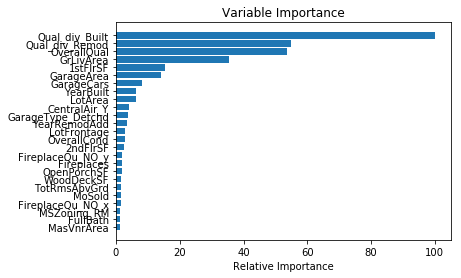

In [546]:
varImpPlot(rf, feature_cols, topN=25, verbose=False)

## 一定の重要度がなければ削除して再度モデル構築

In [547]:
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_cols_ar = np.array(feature_cols)
new_feature_cols = feature_cols_ar[feature_importance > 1]

In [548]:
len(new_feature_cols)

31

In [549]:
len(feature_cols)

272

In [550]:
y = np.array(data2[target_col])
X = np.array(data2[new_feature_cols])

In [551]:
X_train, X_test, y_train, y_test = \
 train_test_split(X, y, test_size=0.3, random_state=1234)

In [552]:
best_params = cv.best_params_

rf = RandomForestRegressor(n_jobs=-1, 
                                max_depth=best_params['max_depth'], 
                                max_features=best_params['max_features'], 
                                min_samples_leaf=best_params['min_samples_leaf'],
                                n_estimators=best_params['n_estimators'])
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)

In [553]:
print("Root Means Square:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=ypred)))

Root Means Square: 0.149911298913


## 予測

In [554]:
test_data = pd.read_csv("dataset/ML_project_test.csv")

In [555]:
# NANに平均値を割り当て
train_col = ['LotFrontage']
for col in train_col:
    test_data[col] = test_data[col].fillna(test_data[col].mean())

In [556]:
# NANに0を割り当て
# 平均値でNANを穴埋め
train_col = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea']
for col in train_col:
    test_data[col] = test_data[col].fillna(0)

In [557]:
# 最頻値を割り当て
train_col = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
for col in train_col:
    dic = {}
    Index = test_data[col].value_counts(dropna=False).index
    for n in range(0,len(Index)):
        dic[test_data[col].value_counts(dropna=False).values[n]] = Index[n]
    test_data[col] = test_data[col].fillna(dic[max(dic)])

In [558]:
# NoでNANを穴埋め
train_col = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType'
             ,'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
for col in train_col:
    test_data[col] = test_data[col].fillna('NO')

In [559]:
# ダミー変数作成
dummy_col = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood'
                                   ,'Condition1','Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType'
                                   ,'HouseStyle','FireplaceQu','PoolQC','Fence','MiscFeature','ExterQual','ExterCond','Foundation','Heating'
                                   ,'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual'
                                   ,'GarageCond','PavedDrive','SaleType','SaleCondition']
#dummy_data = pd.get_dummies(data[dummy_col], drop_first = True) 
dummy_data = pd.get_dummies(test_data[dummy_col], drop_first = True) 
#FireplaceQu,'PoolQC','Fence','MiscFeature'

In [560]:
dummy_data_ot = pd.get_dummies(test_data[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'
                                     ,'FireplaceQu','PoolQC','Fence','MiscFeature']], drop_first = True) 

In [561]:
test_data2 = pd.merge(test_data, dummy_data, left_index=True, right_index=True)
test_data2 = pd.merge(test_data2, dummy_data_ot, left_index=True, right_index=True)


In [562]:
# 特徴量の作成　OverallQual div buily, OverallQual div remodely
test_data2['Qual_div_Built'] = test_data2['OverallQual'] / test_data2['YearBuilt'] 
test_data2['Qual_div_Remod'] = test_data2['OverallQual'] / test_data2['YearRemodAdd'] 
#test_data2['YBuild_div_GarageCar'] = test_data2['YearBuilt'] / (test_data2['GarageCars']+0.01)
#test_data2['GrLivArea_div_BedroomAbvGr'] = test_data2['GrLivArea'] / (test_data2['BedroomAbvGr']+0.01)
test_data2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC_NO_y,Fence_GdWo_y,Fence_MnPrv_y,Fence_MnWw_y,Fence_NO_y,MiscFeature_NO_y,MiscFeature_Othr_y,MiscFeature_Shed_y,Qual_div_Built,Qual_div_Remod
0,1461,20,RH,80.0,11622,Pave,NO,Reg,Lvl,AllPub,...,1,0,1,0,0,1,0,0,0.002550,0.002550
1,1462,20,RL,81.0,14267,Pave,NO,IR1,Lvl,AllPub,...,1,0,0,0,1,0,0,0,0.003064,0.003064
2,1463,60,RL,74.0,13830,Pave,NO,IR1,Lvl,AllPub,...,1,0,1,0,0,1,0,0,0.002504,0.002503
3,1464,60,RL,78.0,9978,Pave,NO,IR1,Lvl,AllPub,...,1,0,0,0,1,1,0,0,0.003003,0.003003
4,1465,120,RL,43.0,5005,Pave,NO,IR1,HLS,AllPub,...,1,0,0,0,1,1,0,0,0.004016,0.004016


In [ ]:
# 整数値を割り当て
train_col = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1'
             ,'Condition2','BldgType','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','HouseStyle','FireplaceQu'
             ,'PoolQC','Fence','MiscFeature','ExterQual','ExterCond','Foundation','Heating','HeatingQC','CentralAir','Electrical'
             ,'KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive'
            ,'PoolQC','Fence','MiscFeature','SaleType','SaleCondition']
for col in train_col:
    Index = test_data[col].value_counts(dropna=False).index
    for n1 in range(0,len(Index)):
        for n in range(0,len(test_data[col])):
            if test_data.loc[n,col] == Index[n1]:
                test_data.loc[n,col] = n1+1

In [563]:
ypred = rf.predict(test_data2[new_feature_cols])

In [564]:
ypred = pd.DataFrame(ypred)

In [565]:
ypred.to_csv("dataset/result_ML14.csv")

In [566]:
new_feature_cols

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'MSZoning_RM',
       'LotShape_Reg', 'FireplaceQu_NO_x', 'ExterCond_Fa', 'CentralAir_Y',
       'GarageType_Attchd', 'GarageType_Detchd', 'GarageFinish_Unf',
       'FireplaceQu_NO_y', 'Qual_div_Built', 'Qual_div_Remod'], 
      dtype='<U21')